# Lab Exercise #3 


### NOTES

- Data Augmentation - (Brightness, Contrast, Rotate)
- Conv2D Filters - 64, 128, 256, 512
- ImgSize = 128x128
+ ReduceLROnPlateau
+ EarlyStopping
+ Flatten
+ Dense
+ Dropout

In [207]:
#%pip install tensorflow
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install pydot
#%pip install scipy

## Dataset Validation

In [197]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Hyperparameters


In [198]:
# For easy modification
height = 128
width = 128
image_size = (height, width)
batch_size = 32
epochs = 50


## Loading the Dataset

In [199]:
import tensorflow as tf

# Load Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

# Load Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 978 files belonging to 3 classes.
Using 783 files for training.
Found 978 files belonging to 3 classes.
Using 195 files for validation.


## Data Profiling and Visualization

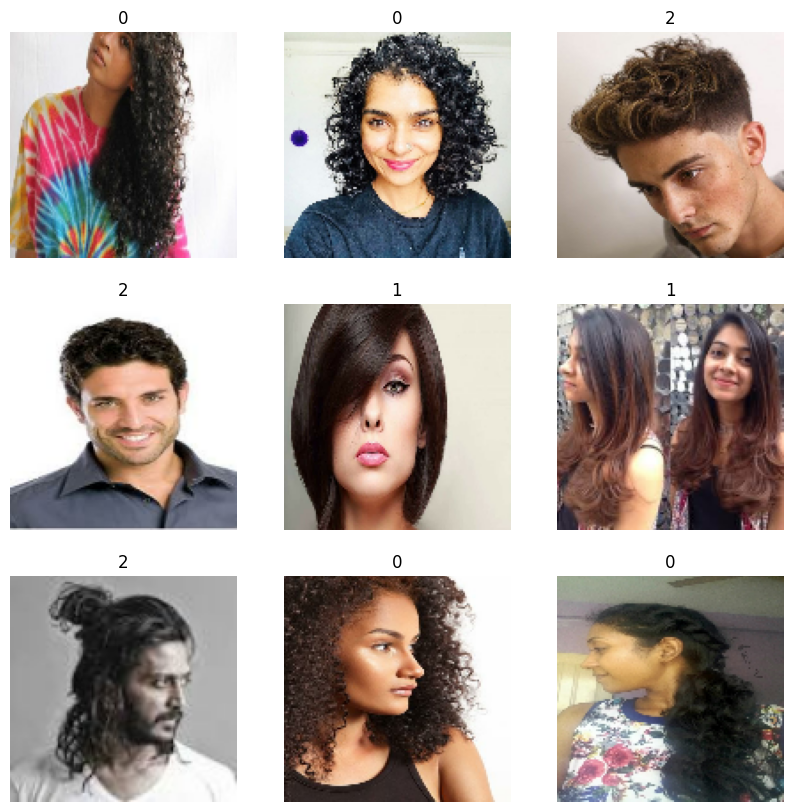

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Shuffle the dataset
train_ds_shuffled = train_ds.shuffle(buffer_size=1000)

plt.figure(figsize=(10, 10))
for images, labels in train_ds_shuffled.take(1):  # Take a batch of images from the shuffled dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
plt.show()

## Data Augmentation

In [201]:
def augment_data(image, label):
    # image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    # image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    image = random_rotate_image(image)
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

augmented_train_ds = train_ds.map(augment_data)


from keras import layers
resize_and_rescale = keras.Sequential([
    layers.Resizing(height=height, width=width),
    layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),
])

---

import tensorflow as tf

def augment_data(image, label):
    # image = tf.image.random_flip_left_right(image)  # Randomly flip images horizontally
    # image = tf.image.random_flip_up_down(image)  # Randomly flip images vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness randomly
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Adjust contrast randomly
    image = random_rotate_image(image)
    return image, label


def random_rotate_image(image):
    random_angle = tf.random.uniform([], minval=0, maxval=12, dtype=tf.int32) * 30  # Generate a random angle between 0 and 330 degrees
    rotated_image = tf.image.rot90(image, k=random_angle // 90)   # Rotate the image by the random angle
    return rotated_image

augmented_train_ds = train_ds.map(augment_data)

-----------------
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()
--------------------------
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

### Data Augmentation Visualization

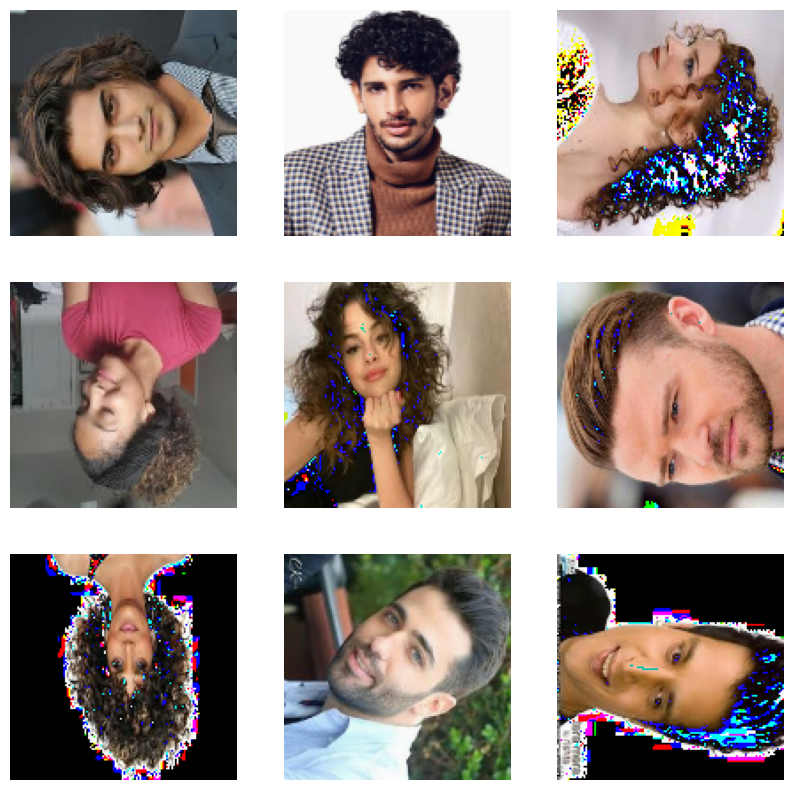

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images, _ = augment_data(images[i], None)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images).astype("uint8"))
        plt.axis("off")
plt.show()

## Model Architecture

In [203]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define your model architecture
model = keras.Sequential([
    keras.Input(shape=image_size + (3,)),
    layers.Rescaling(1.0 / 255),
    # Data Preprocessing layers
    #resize_and_rescale,
    #data_augmentation,
    
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(3, activation="softmax")
])

#class DropConnect(layers.Layer):
    #def __init__(self, rate, **kwargs):
        #super(DropConnect, self).__init__(**kwargs)
        #self.rate = rate

    #def call(self, inputs, training=None):
        #if training:
            #return tf.nn.dropout(inputs, rate=self.rate)
        #return inputs

# Adding normalization layer
#model.add(layers.LayerNormalization())

# Adding DropConnect layer
#model.add(DropConnect(rate=0.5))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with augmented data
model.fit(augmented_train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3495 - loss: nan - val_accuracy: 0.3949 - val_loss: 1.3915
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3314 - loss: nan - val_accuracy: 0.3795 - val_loss: 1.5789
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3857 - loss: nan - val_accuracy: 0.3333 - val_loss: 1.9874
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3743 - loss: nan - val_accuracy: 0.3692 - val_loss: 1.7878
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3734 - loss: nan - val_accuracy: 0.3333 - val_loss: 1.5152
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3929 - loss: nan - val_accuracy: 0.4000 - val_loss: 1.5706
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4002 - loss: nan - val_accuracy: 0.3282 - val_loss: 2.5918
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3764 - loss: nan - val_accuracy: 0.3231 - val_loss: 1.5140
Epoch 9/50
25/25

## Model Evaluation

In [204]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
This image is 0.98 percent curly hair, 0.01 percent straight hair, and 0.01 percent wavy hair.


### Random Picture Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
For the randomly chosen image (besthairstylesforindianmen15_1378796017.jpg) from folder: hair_types/Curly_Hair/, the predicted percentages are: Curly Hair: 77.34%, Straight Hair: 21.24%, Wavy Hair: 1.42%.


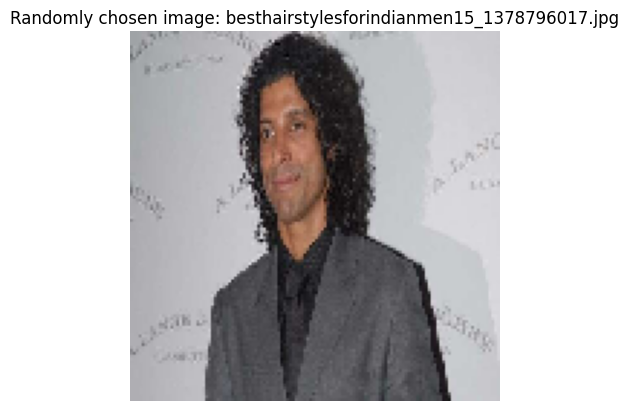

In [205]:
import os
import random
import matplotlib.pyplot as plt

# Set the directory containing your dataset
folder_number = random.randint(1, 3)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "hair_types/Curly_Hair/"
elif folder_number == 2:
    dataset_dir = "hair_types/Straight_Hair/"
else:
    dataset_dir = "hair_types/Wavy_Hair/"

# Get a list of all files in the dataset directory
file_list = os.listdir(dataset_dir)

# Choose a random file from the list
random_file = random.choice(file_list)

# Construct the path to the randomly chosen image
image_path = os.path.join(dataset_dir, random_file)

# Load the image
img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Print the results along with the folder where the image came from
print(
    f"For the randomly chosen image ({random_file}) from folder: {dataset_dir}, the predicted percentages are: Curly Hair: {predictions[0][0] * 100:.2f}%, Straight Hair: {predictions[0][1] * 100:.2f}%, Wavy Hair: {predictions[0][2] * 100:.2f}%."
)

# Display the image
plt.imshow(img)
plt.title("Randomly chosen image: " + random_file)
plt.axis("off")
plt.show()


### Overfit Plot Table

In [206]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'history' is not defined